In [1]:
from polymer_MD_analysis import (pers_length, get_rg_pers_poly, bavg_pers_cnt, pos_bead_autocorr_RA,
                                 rouse_relax, zimm_relax_fit, zimm_relax_func, rh_block_avg, mean_sq_e2e, hydro_rad_poly,
                                orientation_order_param)

In [2]:
#import the necessary modules 
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import scipy
import sklearn
import itertools 
from itertools import cycle 
import os.path as op
import timeit 
import json
import math


In [3]:
import multiprocessing as m_proc
m_proc.cpu_count()

4

In [4]:
# Import MDAnalysis
import MDAnalysis as mda
import statsmodels as stats
from MDAnalysis.analysis import polymer, distances, rdf
import matplotlib.font_manager as font_manager

## PLGA/water system analysis

### N = 6

In [5]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n6_plga_wat = mda.Universe("n6plga_wat/n6plgaonly_wat.pdb", "n6plga_wat/nowat_n6plga.xtc")

In [6]:
n6_plga_wat.trajectory

<XTCReader n6plga_wat/nowat_n6plga.xtc with 18001 frames of 93 atoms>

In [7]:
len(n6_plga_wat.trajectory)

18001

In [8]:
#Select the polymer heavy atoms 
plga_n6wat = n6_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [ ]:
crv_n6plga_wat = pers_length(plga_n6wat,6)
crv_n6plga_wat

In [ ]:
com_bond = np.zeros(shape=(1,18000))
count = 0
for ts in n6_plga_wat.trajectory[0:18000]:
    n6_mon1_wat = n6_plga_wat.select_atoms("resid 1")
    n6_mon2_wat = n6_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n6_mon1_wat.center_of_mass(), n6_mon2_wat.center_of_mass(), 
                                                   box=n6_plga_wat.trajectory.ts.dimensions)
    com_bond[0, count] = oo_len
    count += 1
    

In [ ]:
com_bond

In [ ]:
lb_avg_pn6 = np.mean(com_bond)
lb_avg_pn6

In [ ]:
np.std(com_bond)

### Radius of Gyration vs. time N = 6 PLGA/water system

In [ ]:
n6plga_rgens_wat, cor_n6plga_wat, N6plga_cos_wat, rgwat_n6plga = get_rg_pers_poly(plga_n6wat, n6_plga_wat, 0, 18000)

In [ ]:
n6plga_rgens_wat[0].shape

In [ ]:
cor_n6plga_wat[3]

In [ ]:
N6plga_cos_wat

In [ ]:
rgwat_n6plga

In [ ]:
np.std(n6plga_rgens_wat)

In [ ]:
trj_len = np.arange(18000)

#trj_len += 1
trj_len


In [ ]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n6plga_rgens_wat[0]/10,linewidth=2, color='#CCBE9F')
plt.tick_params(labelsize=14)
plt.legend(['N = 6 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

### Relaxation times vs monomer length 

In [9]:
# Key variables 
# def pos_bead_autocorr_RA(polymer_atoms, universe, n_monomers, t_corr,  start, end):
n_mon = 6 
start = 0
end = 18000
t_corr = 1000
window_shift = 20

In [10]:
s_time = timeit.default_timer()
tcRA_plgan6wat, tcSUM_plgan6wat = pos_bead_autocorr_RA(plga_n6wat, n6_plga_wat, n_mon, t_corr, window_shift, start, end)
timeit.default_timer() - s_time

No. of Samples: 851
0 to 1000
20 to 1020
40 to 1040
60 to 1060
80 to 1080
100 to 1100
120 to 1120
140 to 1140
160 to 1160
180 to 1180
200 to 1200
220 to 1220
240 to 1240
260 to 1260
280 to 1280
300 to 1300
320 to 1320
340 to 1340
360 to 1360
380 to 1380
400 to 1400
420 to 1420
440 to 1440
460 to 1460
480 to 1480
500 to 1500
520 to 1520
540 to 1540
560 to 1560
580 to 1580
600 to 1600
620 to 1620
640 to 1640
660 to 1660
680 to 1680
700 to 1700
720 to 1720
740 to 1740
760 to 1760
780 to 1780
800 to 1800
820 to 1820
840 to 1840
860 to 1860
880 to 1880
900 to 1900
920 to 1920
940 to 1940
960 to 1960
980 to 1980
1000 to 2000
1020 to 2020
1040 to 2040
1060 to 2060
1080 to 2080
1100 to 2100
1120 to 2120
1140 to 2140
1160 to 2160
1180 to 2180
1200 to 2200
1220 to 2220
1240 to 2240
1260 to 2260
1280 to 2280
1300 to 2300
1320 to 2320
1340 to 2340
1360 to 2360
1380 to 2380
1400 to 2400
1420 to 2420
1440 to 2440
1460 to 2460
1480 to 2480
1500 to 2500
1520 to 2520
1540 to 2540
1560 to 2560
1580 to 2

1011.1828689919967

In [11]:
tcSUM_plgan6wat.shape

(851,)

### Fitting autocorrelation data 

In [12]:
xdata_n6wat = tcRA_plgan6wat[1]/100
ydata_n6wat = tcRA_plgan6wat[0]

In [ ]:
ydata_n6wat.shape

In [ ]:
xdata_n6wat.shape

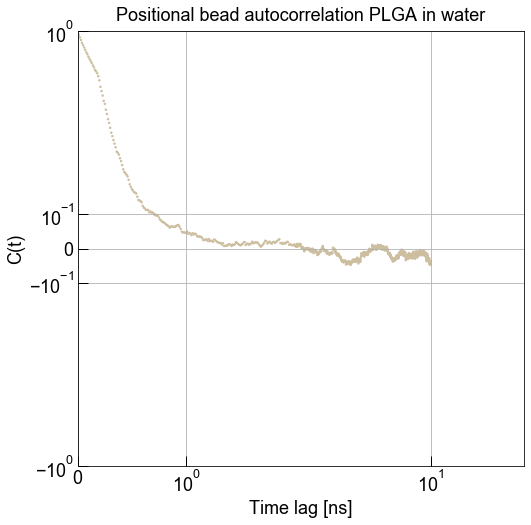

In [13]:
s_n6 =[2 for i in range(len(xdata_n6wat))]
plt.figure(figsize=(8,8))
plt.rcParams["font.family"] = "Arial"
plt.scatter(tcRA_plgan6wat[1]/100, tcRA_plgan6wat[0], color='#CCBE9F', s=s_n6)
plt.title(r'Positional bead autocorrelation PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('C(t)', fontsize=18)
#plt.legend(fontsize=14, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('symlog', linthreshy=0.5)
plt.xscale('symlog')
plt.grid(b=True)
plt.xlim(0,30)
plt.ylim(-1,1)
plt.tick_params(labelsize=18, direction='in', which='both', width=1, length=10)

In [ ]:
rouse_relax(1, 2, 6)

In [ ]:
zimm_relax(1, 2, 0.1, 6)

In [ ]:
def res_polyn6wat(variabls, xnp, ynp):
    hs_np = variabls['h_star']
    tr1_np = variabls['t_first']
    n_m = 6
    testnp = []
    for i in range(len(xnp)):
        model_ynp = zimm_relax(xnp[i], tr1_np, hs_np, n_m)
        #model_ynp = rouse_relax(xnp[i], tr1_np, n_m)
        testnp.append(ynp[i] - model_ynp)
    
    tt_n30 = np.array(testnp)

    return tt_n30
    
#x1 = np.array([0,0])
#pfit, pcov, infodict, errmsg, success = leastsq(res_poly, x1, args=(xdata, ydata), full_output=1)

In [ ]:
from lmfit import Minimizer, Parameters, report_fit

In [ ]:
pfit_n6wat = Parameters()
pfit_n6wat.add(name='h_star', value=0, min=0, max=0.26, vary=True)
pfit_n6wat.add(name='t_first', value=2)

In [ ]:
mini_n6wat = Minimizer(res_polyn6wat, pfit_n6wat, fcn_args=(xdata_n6wat, ydata_n6wat))
out_n6wat = mini_n6wat.leastsq()
#bfit_n10 = ydata_n10ace + out_n10ace.residual 

In [ ]:
report_fit(out_n6wat.params)

In [ ]:
out_n6wat.params

In [ ]:
twat_n6plga = []
for i in range(len(xdata_n6wat)):
    twat_n6plga.append(zimm_relax(xdata_n6wat[i], 0.28, 0.26,  n_mon))


In [ ]:
s_n6 =[2 for i in range(len(xdata_n6wat))]
plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Arial"
plt.scatter(tcorr_plgan6wat[1]/100, tcorr_plgan6wat[0], color='#CCBE9F', s=s_n6)
plt.plot(xdata_n6wat, twat_n6plga, color='#CCBE9F')
plt.title(r'Positional bead autocorrelation PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('C(t)', fontsize=18)
#plt.legend(fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,30])
plt.ylim([-0.7,1])
plt.tick_params(labelsize=15)

In [ ]:
rwat_msen6 = np.array([tcorr_plgan6wat[0] - np.array(twat_n6plga)])
rwat_msen6

In [ ]:
plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Arial"
s_n6 =[2 for i in range(len(xdata_n6wat))]
plt.scatter(xdata_n6wat, rwat_msen6, color='#CCBE9F', s=s_n6)
plt.title(r'Relaxation time Fitting Residuals PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,30])
plt.ylim([-0.7,1])
plt.tick_params(labelsize=15)

#### Correlation values at each arc length for the whole 180 ns trajectory, N = 6 PLGA/water system

In [ ]:
# x values
blen_wat = cor_n6plga_wat[3]*lb_avg_pn6
#nt_tt[0] = 0
blen_wat

In [ ]:
mk_n6p_wat = cor_n6plga_wat[1]/cor_n6plga_wat[0]
mk_n6p_wat

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_wat, np.log(cor_n6plga_wat[0]), yerr=mk_n6p_wat, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [ ]:
# All the points give the best fits for N = 6 peg in water
n6_blksplga_wat , n6plga_lpwat = bavg_pers_cnt(5, plga_n6wat, n6_plga_wat, lb_avg_pn6, 3, 3000 , 18000)

In [ ]:
n6_blksplga_wat

In [ ]:
n6plga_lpwat

In [ ]:
n6plga_lpwat[2]

In [ ]:
np.mean(n6plga_lpwat[3])

In [ ]:
def line_fit(slope, x):
    return slope*x 

In [ ]:
blen_wat

In [ ]:
gg_n6plga_wat = line_fit(np.mean(n6plga_lpwat[2]),blen_wat)

In [ ]:
gg_n6plga_wat

### Block averaged Radius of gyration and persistence length, N = 6 PLGA/water system

In [ ]:
np.mean(n6_blksplga_wat["Avg persistence length"])

In [ ]:
np.std(n6_blksplga_wat["Avg persistence length"])

In [ ]:
np.mean(n6_blksplga_wat["Avg Radius of gyration"])

In [ ]:
np.std(n6_blksplga_wat["Avg Radius of gyration"])

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_wat, np.log(cor_n6plga_wat[0]), yerr=mk_n6p_wat, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(blen_wat, gg_n6plga_wat, color='b')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in water', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
plt.tick_params(labelsize=14)
plt.text(0.5, -1.82,r'$N_{PLGA}$ = 6: $L_{p}$ = 16.0 $\AA$ ± 1.73 $\AA$', fontsize=15, color='b')
#plt.text(5,-0.15,r'R$^{2}$ = 0.98', fontsize=15, color='blue')

In [ ]:
rgplga_olig_wat =  pd.DataFrame(data=n6_blksplga_wat["Avg Radius of gyration"]
                                  , columns=['$R_{g}$ [Angstrom] N = 6 PLGA in water'])
rgplga_olig_wat

In [ ]:
pers_plgat_wat = pd.DataFrame(data=n6_blksplga_wat["Avg persistence length"]
                                , columns=[r"$L_{p}$ [Angstrom] N = 6 PLGA in water"])
pers_plgat_wat

### N = 8 PLGA/water system

In [14]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n8_plga_wat = mda.Universe("n8plga_wat/n8plgaonly_wat.pdb", "n8plga_wat/nowat_n8plga.xtc")

In [15]:
n8_plga_wat.trajectory

<XTCReader n8plga_wat/nowat_n8plga.xtc with 18001 frames of 123 atoms>

In [16]:
len(n8_plga_wat.trajectory)

18001

In [17]:
#Select the polymer heavy atoms 
plga_n8wat = n8_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [ ]:
crv_n8plga_wat = pers_length(plga_n8wat,8)
crv_n8plga_wat

In [ ]:
com_bond_n8wat = np.zeros(shape=(1,18000))
count = 0
for ts in n8_plga_wat.trajectory[0:18000]:
    n8_mon1_wat = n8_plga_wat.select_atoms("resid 1")
    n8_mon2_wat = n8_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n8_mon1_wat.center_of_mass(), n8_mon2_wat.center_of_mass(), 
                                                   box=n8_plga_wat.trajectory.ts.dimensions)
    com_bond_n8wat[0, count] = oo_len
    count += 1
    

In [ ]:
com_bond

In [ ]:
np.std(com_bond)

In [ ]:
lb_avg_pn6 = np.mean(com_bond)
lb_avg_pn6

In [ ]:
np.mean(com_bond_n8wat)

In [ ]:
np.std(com_bond_n8wat)

### Radius of Gyration vs. time N = 8 PLGA/water system

In [ ]:
n8plga_rgens_wat, cor_n8plga_wat, N8plga_cos_wat, rgwat_n8plga = get_rg_pers_poly(plga_n8wat, n8_plga_wat, 0, 18000)

In [ ]:
n8plga_rgens_wat[0].shape

In [ ]:
cor_n8plga_wat[3]

In [ ]:
N8plga_cos_wat

In [ ]:
rgwat_n8plga

In [ ]:
np.std(n8plga_rgens_wat)

In [ ]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n6plga_rgens_wat[0]/10,linewidth=2, color='#CCBE9F')
plt.plot(trj_len/100, n8plga_rgens_wat[0]/10,linewidth=2, color='#601A4A')
plt.tick_params(labelsize=14)
plt.legend(['N = 6 in water','N = 8 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

### Relaxation times vs monomer length 

In [18]:
# Key variables 
# def pos_bead_autocorr_RA(polymer_atoms, universe, n_monomers, t_corr,  start, end):
n8_mon = 8 
start = 0
end = 18000
t_corr = 1000
window_shift = 20

In [19]:
s_time = timeit.default_timer()
tcRA_plgan8wat, tcSUM_plgan8wat = pos_bead_autocorr_RA(plga_n8wat, n8_plga_wat, n8_mon, t_corr, window_shift, start, end)
timeit.default_timer() - s_time

No. of Samples: 851
0 to 1000
20 to 1020
40 to 1040
60 to 1060
80 to 1080
100 to 1100
120 to 1120
140 to 1140
160 to 1160
180 to 1180
200 to 1200
220 to 1220
240 to 1240
260 to 1260
280 to 1280
300 to 1300
320 to 1320
340 to 1340
360 to 1360
380 to 1380
400 to 1400
420 to 1420
440 to 1440
460 to 1460
480 to 1480
500 to 1500
520 to 1520
540 to 1540
560 to 1560
580 to 1580
600 to 1600
620 to 1620
640 to 1640
660 to 1660
680 to 1680
700 to 1700
720 to 1720
740 to 1740
760 to 1760
780 to 1780
800 to 1800
820 to 1820
840 to 1840
860 to 1860
880 to 1880
900 to 1900
920 to 1920
940 to 1940
960 to 1960
980 to 1980
1000 to 2000
1020 to 2020
1040 to 2040
1060 to 2060
1080 to 2080
1100 to 2100
1120 to 2120
1140 to 2140
1160 to 2160
1180 to 2180
1200 to 2200
1220 to 2220
1240 to 2240
1260 to 2260
1280 to 2280
1300 to 2300
1320 to 2320
1340 to 2340
1360 to 2360
1380 to 2380
1400 to 2400
1420 to 2420
1440 to 2440
1460 to 2460
1480 to 2480
1500 to 2500
1520 to 2520
1540 to 2540
1560 to 2560
1580 to 2

1317.7901507499992

In [20]:
tcSUM_plgan8wat.shape

(851,)

### Fitting autocorrelation data 

In [21]:
xdata_n8wat = tcRA_plgan8wat[1]/100
ydata_n8wat = tcRA_plgan8wat[0]

In [ ]:
ydata_n8wat.shape

In [ ]:
xdata_n8wat.shape

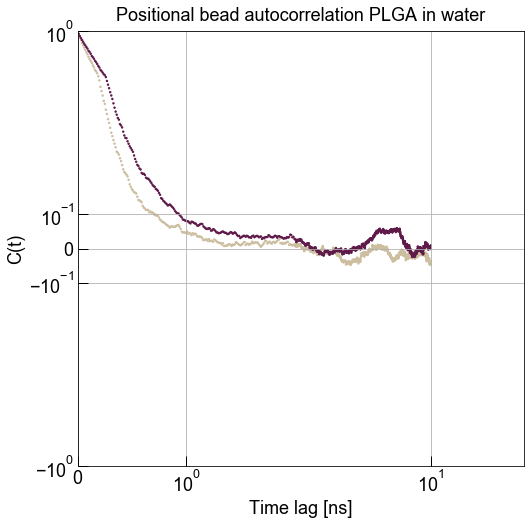

In [22]:
s_n8 =[2 for i in range(len(xdata_n8wat))]
plt.figure(figsize=(8,8))
plt.rcParams["font.family"] = "Arial"
plt.scatter(tcRA_plgan6wat[1]/100, tcRA_plgan6wat[0], color='#CCBE9F', s=s_n6)
plt.scatter(tcRA_plgan8wat[1]/100, tcRA_plgan8wat[0], color='#601A4A', s=s_n8)
plt.title(r'Positional bead autocorrelation PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('C(t)', fontsize=18)
#plt.legend(fontsize=14, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('symlog', linthreshy=0.5)
plt.xscale('symlog')
plt.grid(b=True)
plt.xlim(0,30)
plt.ylim(-1,1)
plt.tick_params(labelsize=18, direction='in', which='both', width=1, length=10)

In [ ]:
def res_polyn8wat(variabls, xnp, ynp):
    hs_np = variabls['h_star']
    tr1_np = variabls['t_first']
    n_m = 8
    testnp = []
    for i in range(len(xnp)):
        model_ynp = zimm_relax(xnp[i], tr1_np, hs_np, n_m)
        #model_ynp = rouse_relax(xnp[i], tr1_np, n_m)
        testnp.append(ynp[i] - model_ynp)
    
    tt_n30 = np.array(testnp)

    return tt_n30
    
#x1 = np.array([0,0])
#pfit, pcov, infodict, errmsg, success = leastsq(res_poly, x1, args=(xdata, ydata), full_output=1)

In [ ]:
pfit_n8wat = Parameters()
pfit_n8wat.add(name='h_star', value=0, min=0, max=0.26, vary=True)
pfit_n8wat.add(name='t_first', value=2)

In [ ]:
mini_n8wat = Minimizer(res_polyn8wat, pfit_n8wat, fcn_args=(xdata_n8wat, ydata_n8wat))
out_n8wat = mini_n8wat.leastsq()
#bfit_n10 = ydata_n10ace + out_n10ace.residual 

In [ ]:
report_fit(out_n8wat.params)

In [ ]:
out_n8wat.params

In [ ]:
twat_n8plga = []
for i in range(len(xdata_n8wat)):
    twat_n8plga.append(zimm_relax(xdata_n8wat[i], 0.53, 0.26,  n_mon))


In [ ]:
s_n8 =[2 for i in range(len(xdata_n8wat))]
plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Arial"
plt.scatter(tcorr_plgan6wat[1]/100, tcorr_plgan6wat[0], color='#CCBE9F', s=s_n6)
plt.scatter(tcorr_plgan8wat[1]/100, tcorr_plgan8wat[0], color='#601A4A', s=s_n8)
plt.plot(xdata_n6wat, twat_n6plga, color='#CCBE9F')
plt.plot(xdata_n8wat, twat_n8plga, color='#601A4A')
plt.title(r'Positional bead autocorrelation PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('C(t)', fontsize=18)
#plt.legend(fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,30])
plt.ylim([-0.7,1])
plt.tick_params(labelsize=15)

In [ ]:
rwat_msen8 = np.array([tcorr_plgan8wat[0] - np.array(twat_n8plga)])
rwat_msen8

In [ ]:
plt.figure(figsize=(10,10))
s_n6 =[2 for i in range(len(xdata_n8wat))]
plt.rcParams["font.family"] = "Arial"
plt.scatter(xdata_n6wat, rwat_msen6, color='#CCBE9F', s=s_n6)
plt.scatter(xdata_n8wat, rwat_msen8, color='#601A4A', s=s_n8)
plt.title(r'Relaxation time Fitting Residuals PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,30])
plt.ylim([-0.7,1])
plt.tick_params(labelsize=15)

#### Correlation values at each arc length for the whole 180 ns trajectory, N = 8 PLGA/water system

In [ ]:
# x values
blen_n8wat = cor_n8plga_wat[3]*lb_avg_pn6
#nt_tt[0] = 0
blen_n8wat

In [ ]:
mk_n8p_wat = cor_n8plga_wat[1]/cor_n8plga_wat[0]
mk_n8p_wat

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_wat, np.log(cor_n6plga_wat[0]), yerr=mk_n6p_wat, color='#CCBE9F', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8wat, np.log(cor_n8plga_wat[0]), yerr=mk_n8p_wat, color='#601A4A', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [ ]:
# All the points give the best fits for N = 6 peg in water
n8_blksplga_wat , n8plga_lpwat = bavg_pers_cnt(5, plga_n8wat, n8_plga_wat, lb_avg_pn6, 4, 3000 , 18000)

In [ ]:
n8_blksplga_wat

In [ ]:
n8plga_lpwat

In [ ]:
n8plga_lpwat[2]

In [ ]:
np.mean(n8plga_lpwat[3])

In [ ]:
blen_n8wat

In [ ]:
gg_n8plga_wat = line_fit(np.mean(n8plga_lpwat[2]),blen_n8wat)

In [ ]:
gg_n6plga_n8wat = line_fit(np.mean(n6plga_lpwat[2]),blen_n8wat)

In [ ]:
gg_n8plga_wat

### Block averaged Radius of gyration and persistence length, N = 8 PLGA/water system

In [ ]:
np.mean(n8_blksplga_wat["Avg persistence length"])

In [ ]:
np.std(n8_blksplga_wat["Avg persistence length"])

In [ ]:
np.mean(n8_blksplga_wat["Avg Radius of gyration"])

In [ ]:
np.std(n8_blksplga_wat["Avg Radius of gyration"])

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_wat, np.log(cor_n6plga_wat[0]), yerr=mk_n6p_wat, color='#CCBE9F', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8wat, np.log(cor_n8plga_wat[0]), yerr=mk_n8p_wat, color='#601A4A', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(blen_n8wat, gg_n6plga_n8wat, color='#CCBE9F')
plt.plot(blen_n8wat, gg_n8plga_wat, color='#601A4A')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in water', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
plt.ylim(-7,1)
plt.xlim(0,165)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
#plt.legend([r'$N_{PEG}$ = 6: $L_{p}$ = 10.7 $\AA$ ± 1.62 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(0.5, -6.92,r'$N_{PLGA}$ = 6: $L_{p}$ = 16.0 $\AA$ ± 1.73 $\AA$', fontsize=15, color='#CCBE9F')
plt.text(0.5, -6.54,r'$N_{PLGA}$ = 8: $L_{p}$ = 17.2 $\AA$ ± 2.13 $\AA$', fontsize=15, color='#601A4A')

In [ ]:
rgplga_olig_wat[r"$R_{g}$ [Angstrom] N = 8 PLGA in water"] = n8_blksplga_wat["Avg Radius of gyration"]
rgplga_olig_wat

In [ ]:
pers_plgat_wat[r"$L_{p}$ [Angstrom] N = 8 PLGA in water"] = n8_blksplga_wat["Avg persistence length"]
pers_plgat_wat

### N = 10 PLGA/water system

In [23]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n10_plga_wat = mda.Universe("n10plga_wat/n10plgaonly_wat.pdb", "n10plga_wat/nowat_n10plga.xtc")

In [24]:
n10_plga_wat.trajectory

<XTCReader n10plga_wat/nowat_n10plga.xtc with 18001 frames of 153 atoms>

In [25]:
len(n10_plga_wat.trajectory)

18001

In [26]:
#Select the polymer heavy atoms 
plga_n10wat = n10_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [ ]:
crv_n10plga_wat = pers_length(plga_n10wat,10)
crv_n10plga_wat

In [ ]:
com_bond_n10wat = np.zeros(shape=(1,18000))
count = 0
for ts in n10_plga_wat.trajectory[0:18000]:
    n10_mon1_wat = n10_plga_wat.select_atoms("resid 1")
    n10_mon2_wat = n10_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n10_mon1_wat.center_of_mass(), n10_mon2_wat.center_of_mass(), 
                                                   box=n10_plga_wat.trajectory.ts.dimensions)
    com_bond_n10wat[0, count] = oo_len
    count += 1
    

In [ ]:
com_bond

In [ ]:
np.std(com_bond)

In [ ]:
lb_avg_pn6 = np.mean(com_bond)
lb_avg_pn6

In [ ]:
np.mean(com_bond_n10wat)

In [ ]:
np.std(com_bond_n10wat)

### Radius of Gyration vs. time N = 10 PLGA/water system

In [ ]:
n10plga_rgens_wat, cor_n10plga_wat, N10plga_cos_wat, rgwat_n10plga = get_rg_pers_poly(plga_n10wat, n10_plga_wat, 0, 18000)

In [ ]:
n10plga_rgens_wat[0].shape

In [ ]:
cor_n10plga_wat[3]

In [ ]:
N10plga_cos_wat

In [ ]:
rgwat_n10plga

In [ ]:
np.std(n10plga_rgens_wat)

In [ ]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n6plga_rgens_wat[0]/10,linewidth=2, color='#CCBE9F')
plt.plot(trj_len/100, n8plga_rgens_wat[0]/10,linewidth=2, color='#601A4A')
plt.plot(trj_len/100, n10plga_rgens_wat[0]/10,linewidth=2, color='#2B6322')
plt.tick_params(labelsize=14)
plt.legend(['N = 6 in water','N = 8 in water','N = 10 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

### Relaxation times vs monomer length 

In [27]:
# Key variables 
# def pos_bead_autocorr_RA(polymer_atoms, universe, n_monomers, t_corr,  start, end):
n10_mon = 10
start = 0
end = 18000
t_corr = 1000
window_shift = 20

In [28]:
s_time = timeit.default_timer()
tcRA_plgan10wat, tcSUM_plgan10wat = pos_bead_autocorr_RA(plga_n10wat, n10_plga_wat, n10_mon, t_corr, window_shift, start, end)
timeit.default_timer() - s_time

No. of Samples: 851
0 to 1000
20 to 1020
40 to 1040
60 to 1060
80 to 1080
100 to 1100
120 to 1120
140 to 1140
160 to 1160
180 to 1180
200 to 1200
220 to 1220
240 to 1240
260 to 1260
280 to 1280
300 to 1300
320 to 1320
340 to 1340
360 to 1360
380 to 1380
400 to 1400
420 to 1420
440 to 1440
460 to 1460
480 to 1480
500 to 1500
520 to 1520
540 to 1540
560 to 1560
580 to 1580
600 to 1600
620 to 1620
640 to 1640
660 to 1660
680 to 1680
700 to 1700
720 to 1720
740 to 1740
760 to 1760
780 to 1780
800 to 1800
820 to 1820
840 to 1840
860 to 1860
880 to 1880
900 to 1900
920 to 1920
940 to 1940
960 to 1960
980 to 1980
1000 to 2000
1020 to 2020
1040 to 2040
1060 to 2060
1080 to 2080
1100 to 2100
1120 to 2120
1140 to 2140
1160 to 2160
1180 to 2180
1200 to 2200
1220 to 2220
1240 to 2240
1260 to 2260
1280 to 2280
1300 to 2300
1320 to 2320
1340 to 2340
1360 to 2360
1380 to 2380
1400 to 2400
1420 to 2420
1440 to 2440
1460 to 2460
1480 to 2480
1500 to 2500
1520 to 2520
1540 to 2540
1560 to 2560
1580 to 2

1642.6015685929997

In [29]:
tcSUM_plgan10wat.shape

(851,)

### Fitting autocorrelation data 

In [30]:
xdata_n10wat = tcRA_plgan10wat[1]/100
ydata_n10wat = tcRA_plgan10wat[0]

In [ ]:
xdata_n10wat.shape

In [ ]:
ydata_n10wat.shape

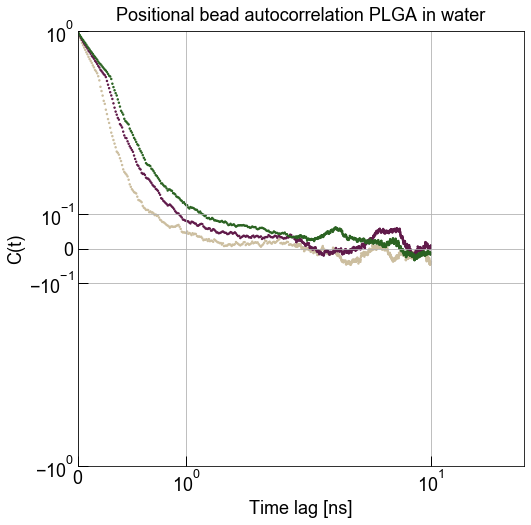

In [31]:
s_n10 =[2 for i in range(len(xdata_n10wat))]
plt.figure(figsize=(8,8))
plt.rcParams["font.family"] = "Arial"
plt.scatter(tcRA_plgan6wat[1]/100, tcRA_plgan6wat[0], color='#CCBE9F', s=s_n6)
plt.scatter(tcRA_plgan8wat[1]/100, tcRA_plgan8wat[0], color='#601A4A', s=s_n8)
plt.scatter(tcRA_plgan10wat[1]/100, tcRA_plgan10wat[0], color='#2B6322', s=s_n10)
plt.title(r'Positional bead autocorrelation PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('C(t)', fontsize=18)
#plt.legend(fontsize=14, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('symlog', linthreshy=0.5)
plt.xscale('symlog')
plt.grid(b=True)
plt.xlim(0,30)
plt.ylim(-1,1)
plt.tick_params(labelsize=18, direction='in', which='both', width=1, length=10)

In [ ]:
def res_polyn10wat(variabls, xnp, ynp):
    hs_np = variabls['h_star']
    tr1_np = variabls['t_first']
    n_m = 10
    testnp = []
    for i in range(len(xnp)):
        model_ynp = zimm_relax(xnp[i], tr1_np, hs_np, n_m)
        #model_ynp = rouse_relax(xnp[i], tr1_np, n_m)
        testnp.append(ynp[i] - model_ynp)
    
    tt_n30 = np.array(testnp)

    return tt_n30
    
#x1 = np.array([0,0])
#pfit, pcov, infodict, errmsg, success = leastsq(res_poly, x1, args=(xdata, ydata), full_output=1)

In [ ]:
pfit_n10wat = Parameters()
pfit_n10wat.add(name='h_star', value=0, min=0, max=0.26, vary=True)
pfit_n10wat.add(name='t_first', value=2)

In [ ]:
mini_n10wat = Minimizer(res_polyn10wat, pfit_n10wat, fcn_args=(xdata_n10wat, ydata_n10wat))
out_n10wat = mini_n10wat.leastsq()
#bfit_n10 = ydata_n10ace + out_n10ace.residual 

In [ ]:
report_fit(out_n10wat.params)

In [ ]:
out_n10wat.params

In [ ]:
twat_n10plga = []
for i in range(len(xdata_n10wat)):
    twat_n10plga.append(zimm_relax(xdata_n10wat[i], 1.82, 3.24e-6,  n_mon))


In [ ]:
s_n10 =[2 for i in range(len(xdata_n10wat))]
plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Arial"
plt.scatter(tcorr_plgan6wat[1]/100, tcorr_plgan6wat[0], color='#CCBE9F', s=s_n6)
plt.scatter(tcorr_plgan8wat[1]/100, tcorr_plgan8wat[0], color='#601A4A', s=s_n8)
plt.scatter(tcorr_plgan10wat[1]/100, tcorr_plgan10wat[0], color='#2B6322', s=s_n10)
plt.plot(xdata_n6wat, twat_n6plga, color='#CCBE9F')
plt.plot(xdata_n8wat, twat_n8plga, color='#601A4A')
plt.plot(xdata_n10wat, twat_n10plga, color='#2B6322')
plt.title(r'Positional bead autocorrelation PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('C(t)', fontsize=18)
#plt.legend(fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,30])
plt.ylim([-0.7,1])
plt.tick_params(labelsize=15)

In [ ]:
rwat_msen10 = np.array([tcorr_plgan10wat[0] - np.array(twat_n10plga)])
rwat_msen10

In [ ]:
plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Arial"
s_n10 =[2 for i in range(len(xdata_n10wat))]
plt.scatter(xdata_n6wat, rwat_msen6, color='#CCBE9F', s=s_n6)
plt.scatter(xdata_n8wat, rwat_msen8, color='#601A4A', s=s_n8)
plt.scatter(xdata_n10wat, rwat_msen10, color='#2B6322', s=s_n10)
plt.title(r'Relaxation time Fitting Residuals PLGA in DMSO', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,30])
plt.ylim([-0.7,1])
plt.tick_params(labelsize=15)

#### Correlation values at each arc length for the whole 180 ns trajectory, N = 10 PLGA/water system

In [ ]:
# x values
blen_n10wat = cor_n10plga_wat[3]*lb_avg_pn6
#nt_tt[0] = 0
blen_n10wat

In [ ]:
mk_n10p_wat = cor_n10plga_wat[1]/cor_n10plga_wat[0]
mk_n10p_wat

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_wat, np.log(cor_n6plga_wat[0]), yerr=mk_n6p_wat, color='#CCBE9F', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8wat, np.log(cor_n8plga_wat[0]), yerr=mk_n8p_wat, color='#601A4A', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n10wat, np.log(cor_n10plga_wat[0]), yerr=mk_n10p_wat, color='#2B6322', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [ ]:
# All the points give the best fits for N = 6 peg in water
n10_blksplga_wat , n10plga_lpwat = bavg_pers_cnt(5, plga_n10wat, n10_plga_wat, lb_avg_pn6, 4, 3000 , 18000)

In [ ]:
n10_blksplga_wat

In [ ]:
n10plga_lpwat

In [ ]:
n10plga_lpwat[2]

In [ ]:
np.mean(n10plga_lpwat[3])

In [ ]:
blen_n10wat

In [ ]:
gg_n10plga_wat = line_fit(np.mean(n10plga_lpwat[2]),blen_n10wat)

In [ ]:
gg_n6plga_n10wat = line_fit(np.mean(n6plga_lpwat[2]),blen_n10wat)

In [ ]:
gg_n8plga_n10wat = line_fit(np.mean(n8plga_lpwat[2]),blen_n10wat)

In [ ]:
gg_n10plga_wat

### Block averaged Radius of gyration and persistence length, N = 10 PLGA/acetone system

In [ ]:
np.mean(n10_blksplga_wat["Avg persistence length"])

In [ ]:
np.std(n10_blksplga_wat["Avg persistence length"])

In [ ]:
np.mean(n10_blksplga_wat["Avg Radius of gyration"])

In [ ]:
np.std(n10_blksplga_wat["Avg Radius of gyration"])

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_wat, np.log(cor_n6plga_wat[0]), yerr=mk_n6p_wat, color='#CCBE9F', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8wat, np.log(cor_n8plga_wat[0]), yerr=mk_n8p_wat, color='#601A4A', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n10wat, np.log(cor_n10plga_wat[0]), yerr=mk_n10p_wat, color='#2B6322', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(blen_n10wat, gg_n6plga_n10wat, color='#CCBE9F')
plt.plot(blen_n10wat, gg_n8plga_n10wat, color='#601A4A')
plt.plot(blen_n10wat, gg_n10plga_wat, color='#2B6322')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in acetone', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
plt.ylim(-7,1)
plt.xlim(0,165)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
#plt.legend([r'$N_{PEG}$ = 6: $L_{p}$ = 10.7 $\AA$ ± 1.62 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(0.5, -6.92,r'$N_{PLGA}$ = 6: $L_{p}$ = 16.0 $\AA$ ± 1.73 $\AA$', fontsize=15, color='#CCBE9F')
plt.text(0.5, -6.54,r'$N_{PLGA}$ = 8: $L_{p}$ = 17.2 $\AA$ ± 2.13 $\AA$', fontsize=15, color='#601A4A')
plt.text(0.5, -6.14,r'$N_{PLGA}$ = 10: $L_{p}$ = 15.8 $\AA$ ± 1.01 $\AA$', fontsize=15, color='#2B6322')

In [ ]:
rgplga_olig_wat[r"$R_{g}$ [Angstrom] N = 10 PLGA in water"] = n10_blksplga_wat["Avg Radius of gyration"]
rgplga_olig_wat

In [ ]:
pers_plgat_wat[r"$L_{p}$ [Angstrom] N = 10 PLGA in water"] = n10_blksplga_wat["Avg persistence length"]
pers_plgat_wat

### N = 20 PLGA/water system

In [32]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n20_plga_wat = mda.Universe("n20plga_wat/n20plgaonly_wat.pdb", "n20plga_wat/nowat_n20plga.xtc")

In [33]:
n20_plga_wat.trajectory

<XTCReader n20plga_wat/nowat_n20plga.xtc with 18001 frames of 303 atoms>

In [34]:
len(n20_plga_wat.trajectory)

18001

In [35]:
#Select the polymer heavy atoms 
plga_n20wat = n20_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [ ]:
crv_n20plga_wat = pers_length(plga_n20wat,20)
crv_n20plga_wat

In [ ]:
com_bond_n20wat = np.zeros(shape=(1,18000))
count = 0
for ts in n20_plga_wat.trajectory[0:18000]:
    n20_mon1_wat = n20_plga_wat.select_atoms("resid 1")
    n20_mon2_wat = n20_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n20_mon1_wat.center_of_mass(), n20_mon2_wat.center_of_mass(), 
                                                   box=n20_plga_wat.trajectory.ts.dimensions)
    com_bond_n20wat[0, count] = oo_len
    count += 1
    

In [ ]:
com_bond

In [ ]:
np.std(com_bond)

In [ ]:
lb_avg_pn6 = np.mean(com_bond)
lb_avg_pn6

In [ ]:
np.mean(com_bond_n20wat)

In [ ]:
np.std(com_bond_n20wat)

### Radius of Gyration vs. time N = 20 PLGA/water system

In [ ]:
n20plga_rgens_wat, cor_n20plga_wat, N20plga_cos_wat, rgwat_n20plga = get_rg_pers_poly(plga_n20wat, n20_plga_wat, 0, 18000)

In [ ]:
n20plga_rgens_wat[0].shape

In [ ]:
cor_n20plga_wat[3]

In [ ]:
N20plga_cos_wat

In [ ]:
rgwat_n20plga

In [ ]:
np.std(n20plga_rgens_wat)

In [ ]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n6plga_rgens_wat[0]/10,linewidth=2, color='#CCBE9F')
plt.plot(trj_len/100, n8plga_rgens_wat[0]/10,linewidth=2, color='#601A4A')
plt.plot(trj_len/100, n10plga_rgens_wat[0]/10,linewidth=2, color='#2B6322')
plt.plot(trj_len/100, n20plga_rgens_wat[0]/10,linewidth=2, color='#562A8B')
plt.tick_params(labelsize=14)
plt.legend(['N = 6 in water','N = 8 in water','N = 10 in water','N = 20 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,2)

### Relaxation times vs monomer length 

In [60]:
# Key variables 
# def pos_bead_autocorr_RA(polymer_atoms, universe, n_monomers, t_corr,  start, end):
n20_mon = 20
start = 0
end = 18000
t_corr = 2500
window_shift = 20

In [61]:
s_time = timeit.default_timer()
tcRA_plgan20wat, tcSUM_plgan20wat = pos_bead_autocorr_RA(plga_n20wat, n20_plga_wat, n20_mon, t_corr, window_shift, start, end)
timeit.default_timer() - s_time

No. of Samples: 776
0 to 2500
20 to 2520
40 to 2540
60 to 2560
80 to 2580
100 to 2600
120 to 2620
140 to 2640
160 to 2660
180 to 2680
200 to 2700
220 to 2720
240 to 2740
260 to 2760
280 to 2780
300 to 2800
320 to 2820
340 to 2840
360 to 2860
380 to 2880
400 to 2900
420 to 2920
440 to 2940
460 to 2960
480 to 2980
500 to 3000
520 to 3020
540 to 3040
560 to 3060
580 to 3080
600 to 3100
620 to 3120
640 to 3140
660 to 3160
680 to 3180
700 to 3200
720 to 3220
740 to 3240
760 to 3260
780 to 3280
800 to 3300
820 to 3320
840 to 3340
860 to 3360
880 to 3380
900 to 3400
920 to 3420
940 to 3440
960 to 3460
980 to 3480
1000 to 3500
1020 to 3520
1040 to 3540
1060 to 3560
1080 to 3580
1100 to 3600
1120 to 3620
1140 to 3640
1160 to 3660
1180 to 3680
1200 to 3700
1220 to 3720
1240 to 3740
1260 to 3760
1280 to 3780
1300 to 3800
1320 to 3820
1340 to 3840
1360 to 3860
1380 to 3880
1400 to 3900
1420 to 3920
1440 to 3940
1460 to 3960
1480 to 3980
1500 to 4000
1520 to 4020
1540 to 4040
1560 to 4060
1580 to 4

6949.024230260999

In [39]:
tcSUM_plgan20wat.shape

(826,)

### Fitting autocorrelation data 

In [62]:
xdata_n20wat = tcRA_plgan20wat[1]/100
ydata_n20wat = tcRA_plgan20wat[0]

In [ ]:
xdata_n20wat.shape

In [ ]:
xdata_n20wat.shape

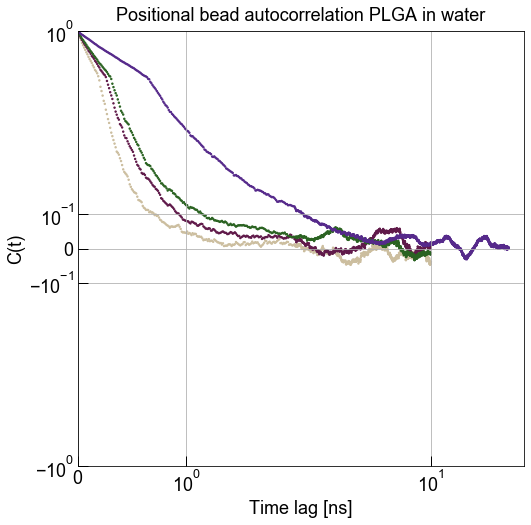

In [63]:
s_n20 =[2 for i in range(len(xdata_n20wat))]
plt.figure(figsize=(8,8))
plt.rcParams["font.family"] = "Arial"
plt.scatter(tcRA_plgan6wat[1]/100, tcRA_plgan6wat[0], color='#CCBE9F', s=s_n6)
plt.scatter(tcRA_plgan8wat[1]/100, tcRA_plgan8wat[0], color='#601A4A', s=s_n8)
plt.scatter(tcRA_plgan10wat[1]/100, tcRA_plgan10wat[0], color='#2B6322', s=s_n10)
plt.scatter(tcRA_plgan20wat[1]/100, tcRA_plgan20wat[0], color='#562A8B', s=s_n20)
plt.title(r'Positional bead autocorrelation PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('C(t)', fontsize=18)
#plt.legend(fontsize=14, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('symlog', linthreshy=0.5)
plt.xscale('symlog')
plt.grid(b=True)
plt.xlim(0,30)
plt.ylim(-1,1)
plt.tick_params(labelsize=18, direction='in', which='both', width=1, length=10)

In [ ]:
def res_polyn20wat(variabls, xnp, ynp):
    hs_np = variabls['h_star']
    tr1_np = variabls['t_first']
    n_m = 20
    testnp = []
    for i in range(len(xnp)):
        model_ynp = zimm_relax(xnp[i], tr1_np, hs_np, n_m)
        #model_ynp = rouse_relax(xnp[i], tr1_np, n_m)
        testnp.append(ynp[i] - model_ynp)
    
    tt_n30 = np.array(testnp)

    return tt_n30
    
#x1 = np.array([0,0])
#pfit, pcov, infodict, errmsg, success = leastsq(res_poly, x1, args=(xdata, ydata), full_output=1)

In [ ]:
pfit_n20wat = Parameters()
pfit_n20wat.add(name='h_star', value=0, min=0, max=0.26, vary=True)
pfit_n20wat.add(name='t_first', value=2)

In [ ]:
mini_n20wat = Minimizer(res_polyn20wat, pfit_n20wat, fcn_args=(xdata_n20wat, ydata_n20wat))
out_n20wat = mini_n20wat.leastsq()
#bfit_n10 = ydata_n10ace + out_n10ace.residual 

In [ ]:
report_fit(out_n20wat.params)

In [ ]:
out_n20wat.params

In [ ]:
twat_n20plga = []
for i in range(len(xdata_n20wat)):
    twat_n20plga.append(zimm_relax(xdata_n20wat[i], 0.96, 0.26,  n_mon))

In [ ]:
s_n20 =[2 for i in range(len(xdata_n20wat))]
plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Arial"
plt.scatter(tcorr_plgan6wat[1]/100, tcorr_plgan6wat[0], color='#CCBE9F', s=s_n6)
plt.scatter(tcorr_plgan8wat[1]/100, tcorr_plgan8wat[0], color='#601A4A', s=s_n8)
plt.scatter(tcorr_plgan10wat[1]/100, tcorr_plgan10wat[0], color='#2B6322', s=s_n10)
plt.scatter(tcorr_plgan20wat[1]/100, tcorr_plgan20wat[0], color='#562A8B', s=s_n20)
plt.plot(xdata_n6wat, twat_n6plga, color='#CCBE9F')
plt.plot(xdata_n8wat, twat_n8plga, color='#601A4A')
plt.plot(xdata_n10wat, twat_n10plga, color='#2B6322')
plt.plot(xdata_n20wat, twat_n20plga, color='#562A8B')
plt.title(r'Positional bead autocorrelation PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('C(t)', fontsize=18)
#plt.legend(fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,30])
plt.ylim([-0.7,1])
plt.tick_params(labelsize=15)

In [ ]:
rwat_msen20 = np.array([tcorr_plgan20wat[0] - np.array(twat_n20plga)])
rwat_msen20

In [ ]:
plt.figure(figsize=(10,10))
s_n20 =[2 for i in range(len(xdata_n20wat))]
plt.rcParams["font.family"] = "Arial"
plt.scatter(xdata_n6wat, rwat_msen6, color='#CCBE9F', s=s_n6)
plt.scatter(xdata_n8wat, rwat_msen8, color='#601A4A', s=s_n8)
plt.scatter(xdata_n10wat, rwat_msen10, color='#2B6322', s=s_n10)
plt.scatter(xdata_n20wat, rwat_msen20, color='#562A8B', s=s_n20)
plt.title(r'Relaxation time Fitting Residuals PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,30])
plt.ylim([-0.7,1])
font = font_manager.FontProperties(family='Cambria', style='normal', size='15')
plt.tick_params(labelsize=15)

#### Correlation values at each arc length for the whole 180 ns trajectory, N = 20 PLGA/water system

In [ ]:
# x values
blen_n20wat = cor_n20plga_wat[3]*lb_avg_pn6
#nt_tt[0] = 0
blen_n20wat

In [ ]:
mk_n20p_wat = cor_n20plga_wat[1]/cor_n20plga_wat[0]
mk_n20p_wat

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_wat, np.log(cor_n6plga_wat[0]), yerr=mk_n6p_wat, color='#CCBE9F', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8wat, np.log(cor_n8plga_wat[0]), yerr=mk_n8p_wat, color='#601A4A', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n10wat, np.log(cor_n10plga_wat[0]), yerr=mk_n10p_wat, color='#2B6322', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n20wat, np.log(cor_n20plga_wat[0]), yerr=mk_n20p_wat, color='#562A8B', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [ ]:
# All the points give the best fits for N = 6 peg in water
n20_blksplga_wat, n20plga_lpwat = bavg_pers_cnt(5, plga_n20wat, n20_plga_wat, lb_avg_pn6, 4, 3000 , 18000)

In [ ]:
n20_blksplga_wat

In [ ]:
n20plga_lpwat

In [ ]:
n20plga_lpwat[2]

In [ ]:
np.mean(n20plga_lpwat[3])

In [ ]:
blen_n20wat

In [ ]:
gg_n20plga_wat = line_fit(np.mean(n20plga_lpwat[2]),blen_n20wat)

In [ ]:
gg_n6plga_n20wat = line_fit(np.mean(n6plga_lpwat[2]),blen_n20wat)

In [ ]:
gg_n8plga_n20wat = line_fit(np.mean(n8plga_lpwat[2]),blen_n20wat)

In [ ]:
gg_n10plga_n20wat = line_fit(np.mean(n10plga_lpwat[2]),blen_n20wat)

In [ ]:
gg_n20plga_wat

### Block averaged Radius of gyration and persistence length, N = 20 PLGA/water system

In [ ]:
np.mean(n20_blksplga_wat["Avg persistence length"])

In [ ]:
np.std(n20_blksplga_wat["Avg persistence length"])

In [ ]:
np.mean(n20_blksplga_wat["Avg Radius of gyration"])

In [ ]:
np.std(n20_blksplga_wat["Avg Radius of gyration"])

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_wat, np.log(cor_n6plga_wat[0]), yerr=mk_n6p_wat, color='#CCBE9F', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8wat, np.log(cor_n8plga_wat[0]), yerr=mk_n8p_wat, color='#601A4A', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n10wat, np.log(cor_n10plga_wat[0]), yerr=mk_n10p_wat, color='#2B6322', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n20wat, np.log(cor_n20plga_wat[0]), yerr=mk_n20p_wat, color='#562A8B', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(blen_n20wat[:15], gg_n6plga_n20wat[:15], color='#CCBE9F')
plt.plot(blen_n20wat[:15], gg_n8plga_n20wat[:15], color='#601A4A')
plt.plot(blen_n20wat[:15], gg_n10plga_n20wat[:15], color='#2B6322')
plt.plot(blen_n20wat[:15], gg_n20plga_wat[:15], color='#562A8B')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in water', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
plt.ylim(-7,1)
plt.xlim(0,165)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
#plt.legend([r'$N_{PEG}$ = 6: $L_{p}$ = 10.7 $\AA$ ± 1.62 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(0.5, -6.92,r'$N_{PLGA}$ = 6: $L_{p}$ = 16.0 $\AA$ ± 1.73 $\AA$', fontsize=15, color='#CCBE9F')
plt.text(0.5, -6.54,r'$N_{PLGA}$ = 8: $L_{p}$ = 17.2 $\AA$ ± 2.13 $\AA$', fontsize=15, color='#601A4A')
plt.text(0.5, -6.14,r'$N_{PLGA}$ = 10: $L_{p}$ = 15.8 $\AA$ ± 1.01  $\AA$', fontsize=15, color='#2B6322')
plt.text(0.5, -5.70,r'$N_{PLGA}$ = 20: $L_{p}$ = 17.6 $\AA$ ± 1.49 $\AA$', fontsize=15, color='#562A8B')

In [ ]:
rgplga_olig_wat[r"$R_{g}$ [Angstrom] N = 20 PLGA in water"] = n20_blksplga_wat["Avg Radius of gyration"]
rgplga_olig_wat

In [ ]:
pers_plgat_wat[r"$L_{p}$ [Angstrom] N = 20 PLGA in water"] = n20_blksplga_wat["Avg persistence length"]
pers_plgat_wat

### N = 30 PLGA/water system

In [43]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n30_plga_wat = mda.Universe("n30plga_wat/n30plgaonly_wat.pdb", "n30plga_wat/nowat_n30plga.xtc")

In [44]:
n30_plga_wat.trajectory

<XTCReader n30plga_wat/nowat_n30plga.xtc with 18001 frames of 453 atoms>

In [45]:
len(n30_plga_wat.trajectory)

18001

In [46]:
#Select the polymer heavy atoms 
plga_n30wat = n30_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [ ]:
crv_n30plga_wat = pers_length(plga_n30wat,30)
crv_n30plga_wat

In [ ]:
com_bond_n30wat = np.zeros(shape=(1,18000))
count = 0
for ts in n30_plga_wat.trajectory[0:18000]:
    n30_mon1_wat = n30_plga_wat.select_atoms("resid 1")
    n30_mon2_wat = n30_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n30_mon1_wat.center_of_mass(), n30_mon2_wat.center_of_mass(), 
                                                   box=n30_plga_wat.trajectory.ts.dimensions)
    com_bond_n30wat[0, count] = oo_len
    count += 1
    

In [ ]:
com_bond

In [ ]:
np.std(com_bond)

In [ ]:
lb_avg_pn6 = np.mean(com_bond)
lb_avg_pn6

In [ ]:
np.mean(com_bond_n30wat)

In [ ]:
np.std(com_bond_n30wat)

### Radius of Gyration vs. time N = 30 PLGA/water system

In [ ]:
n30plga_rgens_wat, cor_n30plga_wat, N30plga_cos_wat, rgwat_n30plga = get_rg_pers_poly(plga_n30wat, n30_plga_wat, 0, 18000)

In [ ]:
n30plga_rgens_wat[0].shape

In [ ]:
cor_n30plga_wat[3]

In [ ]:
N30plga_cos_wat

In [ ]:
rgwat_n30plga

In [ ]:
np.std(n30plga_rgens_wat)

In [ ]:
plt.figure(figsize=(7,7))
plt.title(r'PLGA Radius of Gyration', fontsize=18, y=1.01)
plt.xlabel(r'Time [ns]', fontsize=15)
plt.ylabel(r'$R_{g}$ [nm]', fontsize=15)
plt.plot(trj_len/100, n6plga_rgens_wat[0]/10,linewidth=2, color='#CCBE9F')
plt.plot(trj_len/100, n8plga_rgens_wat[0]/10,linewidth=2, color='#601A4A')
plt.plot(trj_len/100, n10plga_rgens_wat[0]/10,linewidth=2, color='#2B6322')
plt.plot(trj_len/100, n20plga_rgens_wat[0]/10,linewidth=2, color='#562A8B')
plt.plot(trj_len/100, n30plga_rgens_wat[0]/10,linewidth=2, color='#1D77CF')
plt.tick_params(labelsize=14)
plt.legend(['N = 6 in water','N = 8 in water','N = 10 in water','N = 20 in water','N = 30 in water'], frameon=False, fontsize=14)
#plt.text(127, 0.96,r'N = 6 in water', fontsize=18, color='#1F2E69', family='Arial')
plt.xlim(0,180)
plt.ylim(0.2,3)

In [ ]:
np.save('n6plga_watRg.npy', n6plga_rgens_wat[0])
np.save('n8plga_watRg.npy', n8plga_rgens_wat[0])
np.save('n10plga_watRg.npy', n10plga_rgens_wat[0])
np.save('n20plga_watRg.npy', n20plga_rgens_wat[0])
np.save('n30plga_watRg.npy', n30plga_rgens_wat[0])

### Relaxation times vs monomer length 

In [53]:
# Key variables 
# def pos_bead_autocorr_RA(polymer_atoms, universe, n_monomers, t_corr,  start, end):
n30_mon = 30
start = 0
end = 18000
t_corr = 4000
window_shift = 20

In [54]:
s_time = timeit.default_timer()
tcRA_plgan30wat, tcSUM_plgan30wat = pos_bead_autocorr_RA(plga_n30wat, n30_plga_wat, n30_mon, t_corr, window_shift, start, end)
timeit.default_timer() - s_time

No. of Samples: 701
0 to 4000
20 to 4020
40 to 4040
60 to 4060
80 to 4080
100 to 4100
120 to 4120
140 to 4140
160 to 4160
180 to 4180
200 to 4200
220 to 4220
240 to 4240
260 to 4260
280 to 4280
300 to 4300
320 to 4320
340 to 4340
360 to 4360
380 to 4380
400 to 4400
420 to 4420
440 to 4440
460 to 4460
480 to 4480
500 to 4500
520 to 4520
540 to 4540
560 to 4560
580 to 4580
600 to 4600
620 to 4620
640 to 4640
660 to 4660
680 to 4680
700 to 4700
720 to 4720
740 to 4740
760 to 4760
780 to 4780
800 to 4800
820 to 4820
840 to 4840
860 to 4860
880 to 4880
900 to 4900
920 to 4920
940 to 4940
960 to 4960
980 to 4980
1000 to 5000
1020 to 5020
1040 to 5040
1060 to 5060
1080 to 5080
1100 to 5100
1120 to 5120
1140 to 5140
1160 to 5160
1180 to 5180
1200 to 5200
1220 to 5220
1240 to 5240
1260 to 5260
1280 to 5280
1300 to 5300
1320 to 5320
1340 to 5340
1360 to 5360
1380 to 5380
1400 to 5400
1420 to 5420
1440 to 5440
1460 to 5460
1480 to 5480
1500 to 5500
1520 to 5520
1540 to 5540
1560 to 5560
1580 to 5

16682.25632994699

In [55]:
tcRA_plgan30wat.shape

(2, 4000)

In [56]:
tcSUM_plgan30wat.shape

(701,)

### Fitting autocorrelation data 

In [57]:
xdata_n30wat = tcRA_plgan30wat[1]/100
ydata_n30wat = tcRA_plgan30wat[0]

In [ ]:
xdata_n30wat.shape

In [ ]:
ydata_n30wat.shape

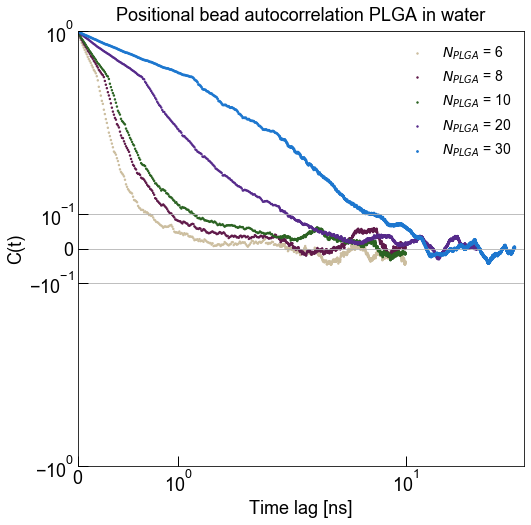

In [67]:
s_n30 =[3 for i in range(len(xdata_n30wat))]
plt.figure(figsize=(8,8))
plt.rcParams["font.family"] = "Arial"
plt.scatter(tcRA_plgan6wat[1]/100, tcRA_plgan6wat[0], color='#CCBE9F', s=s_n6, label=r'$N_{PLGA}$ = 6')
plt.scatter(tcRA_plgan8wat[1]/100, tcRA_plgan8wat[0], color='#601A4A', s=s_n8, label=r'$N_{PLGA}$ = 8')
plt.scatter(tcRA_plgan10wat[1]/100, tcRA_plgan10wat[0], color='#2B6322', s=s_n10, label=r'$N_{PLGA}$ = 10')
plt.scatter(tcRA_plgan20wat[1]/100, tcRA_plgan20wat[0], color='#562A8B', s=s_n20, label=r'$N_{PLGA}$ = 20')
plt.scatter(tcRA_plgan30wat[1]/100, tcRA_plgan30wat[0], color='#1D77CF', s=s_n30, label=r'$N_{PLGA}$ = 30')
plt.title(r'Positional bead autocorrelation PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('C(t)', fontsize=18)
plt.legend(fontsize=14, frameon=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('symlog', linthreshy=0.5)
plt.xscale('symlog')
plt.grid(b=True, axis='y')
plt.xlim(0,45)
plt.ylim(-1,1)
plt.tick_params(labelsize=18, direction='in', which='both', width=1, length=10)

In [66]:
np.save('n6plga_WATCt_RA.npy', tcRA_plgan6wat)
np.save('n8plga_WATCt_RA.npy', tcRA_plgan8wat)
np.save('n10plga_WATCt_RA.npy', tcRA_plgan10wat)
np.save('n20plga_WATCt_RA.npy', tcRA_plgan20wat)
np.save('n30plga_WATCt_RA.npy', tcRA_plgan30wat)

In [ ]:
def res_polyn30wat(variabls, xnp, ynp):
    hs_np = variabls['h_star']
    tr1_np = variabls['t_first']
    n_m = 30
    testnp = []
    for i in range(len(xnp)):
        model_ynp = zimm_relax(xnp[i], tr1_np, hs_np, n_m)
        #model_ynp = rouse_relax(xnp[i], tr1_np, n_m)
        testnp.append(ynp[i] - model_ynp)
    
    tt_n30 = np.array(testnp)

    return tt_n30
    
#x1 = npdmso.array([0,0])
#pfit, pcov, infodict, errmsg, success = leastsq(res_poly, x1, args=(xdata, ydata), full_output=1)

In [ ]:
pfit_n30wat = Parameters()
pfit_n30wat.add(name='h_star', value=0, min=0, max=0.26, vary=True)
pfit_n30wat.add(name='t_first', value=2)

In [ ]:
mini_n30wat = Minimizer(res_polyn30wat, pfit_n30wat, fcn_args=(xdata_n30wat, ydata_n30wat))
out_n30wat = mini_n30wat.leastsq()
#bfit_n10 = ydata_n10ace + out_n10ace.residual 

In [ ]:
report_fit(out_n30wat.params)

In [ ]:
out_n30wat.params

In [ ]:
twat_n30plga = []
for i in range(len(xdata_n30wat)):
    twat_n30plga.append(zimm_relax(xdata_n30wat[i], 4.23, 0.26, n30_mon))

In [ ]:
s_n30 =[2 for i in range(len(xdata_n30wat))]
plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Arial"
plt.scatter(tcorr_plgan6wat[1]/100, tcorr_plgan6wat[0], color='#CCBE9F', s=s_n6)
plt.scatter(tcorr_plgan8wat[1]/100, tcorr_plgan8wat[0], color='#601A4A', s=s_n8)
plt.scatter(tcorr_plgan10wat[1]/100, tcorr_plgan10wat[0], color='#2B6322', s=s_n10)
plt.scatter(tcorr_plgan20wat[1]/100, tcorr_plgan20wat[0], color='#562A8B', s=s_n20)
plt.scatter(tcorr_plgan30wat[1]/100, tcorr_plgan30wat[0], color='#1D77CF', s=s_n30)
plt.plot(xdata_n6wat, twat_n6plga, color='#CCBE9F')
plt.plot(xdata_n8wat, twat_n8plga, color='#601A4A')
plt.plot(xdata_n10wat, twat_n10plga, color='#2B6322')
plt.plot(xdata_n20wat, twat_n20plga, color='#562A8B')
plt.plot(xdata_n30wat, twat_n30plga, color='#1D77CF')
plt.title(r'Positional bead autocorrelation PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('C(t)', fontsize=18)
#plt.legend(fontsize=14, frameon=False)
plt.text(10, 0.95, r'$N_{PLGA}$ = 6:  $\tau_{1}$ = 0.28 ± 0.03 ns, $h^{*}$ = 0.26 ± 0.43', fontsize=15, color='#CCBE9F')
plt.text(10, 0.90, r'$N_{PLGA}$ = 8:  $\tau_{1}$ = 0.53 ± 0.04 ns, $h^{*}$ = 0.26 ± 0.29', fontsize=15, color='#601A4A')
plt.text(10, 0.85, r'$N_{PLGA}$ = 10: $\tau_{1}$ = 1.82 ± 0.06 ns, $h^{*}$ = 3.2e-6 ± 0.01', fontsize=15, color='#2B6322')
plt.text(10, 0.80, r'$N_{PLGA}$ = 20: $\tau_{1}$ = 0.96 ± 0.04 ns, $h^{*}$ = 0.26 ± 0.10 ', fontsize=15, color='#562A8B')
plt.text(10, 0.75, r'$N_{PLGA}$ = 30: $\tau_{1}$ = 4.23 ± 0.06 ns, $h^{*}$ = 0.26 ± 0.03', fontsize=15, color='#1D77CF')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,30])
plt.ylim([-0.7,1])
plt.tick_params(labelsize=15)

In [ ]:
rwat_msen30 = np.array([tcorr_plgan30wat[0] - np.array(twat_n30plga)])
rwat_msen30

In [ ]:
plt.figure(figsize=(10,10))
s_n30 =[10 for i in range(len(xdata_n30wat))]
plt.rcParams["font.family"] = "Arial"
plt.scatter(xdata_n6wat, rwat_msen6, color='#CCBE9F', s=s_n30, label=r'$N_{PLGA}$ = 6' )
plt.scatter(xdata_n8wat, rwat_msen8, color='#601A4A', s=s_n30, label=r'$N_{PLGA}$ = 8')
plt.scatter(xdata_n10wat, rwat_msen10, color='#2B6322', s=s_n30, label=r'$N_{PLGA}$ = 10')
plt.scatter(xdata_n20wat, rwat_msen20, color='#562A8B', s=s_n30, label=r'$N_{PLGA}$ = 20')
plt.scatter(xdata_n30wat, rwat_msen30, color='#1D77CF', s=s_n30, label=r'$N_{PLGA}$ = 30')
plt.title(r'Relaxation time Fitting Residuals PLGA in water', fontsize=18, y=1.01)
plt.xlabel(r'Time lag [ns]', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.legend(fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,30])
plt.ylim([-0.7,1])
font = font_manager.FontProperties(family='Cambria', style='normal', size='15')
plt.tick_params(labelsize=15)

#### Correlation values at each arc length for the whole 180 ns trajectory, N = 30 PLGA/water system

In [ ]:
# x values
blen_n30wat = cor_n30plga_wat[3]*lb_avg_pn6
#nt_tt[0] = 0
blen_n30wat

In [ ]:
mk_n30p_wat = cor_n30plga_wat[1]/cor_n30plga_wat[0]
mk_n30p_wat

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_wat, np.log(cor_n6plga_wat[0]), yerr=mk_n6p_wat, color='#CCBE9F', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8wat, np.log(cor_n8plga_wat[0]), yerr=mk_n8p_wat, color='#601A4A', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n10wat, np.log(cor_n10plga_wat[0]), yerr=mk_n10p_wat, color='#2B6322', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n20wat, np.log(cor_n20plga_wat[0]), yerr=mk_n20p_wat, color='#562A8B', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n30wat, np.log(cor_n30plga_wat[0]), yerr=mk_n30p_wat, color='#1D77CF', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [ ]:
# All the points give the best fits for N = 6 peg in water
n30_blksplga_wat , n30plga_lpwat = bavg_pers_cnt(5, plga_n30wat, n30_plga_wat, lb_avg_pn6, 4, 3000 , 18000)

In [ ]:
n30_blksplga_wat

In [ ]:
n30plga_lpwat

In [ ]:
n30plga_lpwat[2]

In [ ]:
np.mean(n30plga_lpwat[3])

In [ ]:
blen_n30wat

In [ ]:
gg_n30plga_wat = line_fit(np.mean(n30plga_lpwat[2]),blen_n30wat)

In [ ]:
gg_n6plga_n30wat = line_fit(np.mean(n6plga_lpwat[2]),blen_n30wat)

In [ ]:
gg_n8plga_n30wat = line_fit(np.mean(n8plga_lpwat[2]),blen_n30wat)

In [ ]:
gg_n10plga_n30wat = line_fit(np.mean(n10plga_lpwat[2]),blen_n30wat)

In [ ]:
gg_n20plga_n30wat = line_fit(np.mean(n20plga_lpwat[2]),blen_n30wat)

In [ ]:
gg_n30plga_wat

### Block averaged Radius of gyration and persistence length, N = 30 PLGA/water system

In [ ]:
np.mean(n30_blksplga_wat["Avg persistence length"])

In [ ]:
np.std(n30_blksplga_wat["Avg persistence length"])

In [ ]:
np.mean(n30_blksplga_wat["Avg Radius of gyration"])

In [ ]:
np.std(n30_blksplga_wat["Avg Radius of gyration"])

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(blen_wat, np.log(cor_n6plga_wat[0]), yerr=mk_n6p_wat, color='#CCBE9F', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n8wat, np.log(cor_n8plga_wat[0]), yerr=mk_n8p_wat, color='#601A4A', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n10wat, np.log(cor_n10plga_wat[0]), yerr=mk_n10p_wat, color='#2B6322', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n20wat, np.log(cor_n20plga_wat[0]), yerr=mk_n20p_wat, color='#562A8B', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.errorbar(blen_n30wat, np.log(cor_n30plga_wat[0]), yerr=mk_n30p_wat, color='#1D77CF', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(blen_n30wat[:15], gg_n6plga_n30wat[:15], color='#CCBE9F')
plt.plot(blen_n30wat[:15], gg_n8plga_n30wat[:15], color='#601A4A')
plt.plot(blen_n30wat[:15], gg_n10plga_n30wat[:15], color='#2B6322')
plt.plot(blen_n30wat[:15], gg_n20plga_n30wat[:15], color='#562A8B')
plt.plot(blen_n30wat[:15], gg_n30plga_wat[:15], color='#1D77CF')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in water', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
plt.ylim(-7,1)
plt.xlim(0,165)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
#plt.legend([r'$N_{PEG}$ = 6: $L_{p}$ = 10.7 $\AA$ ± 1.62 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(0.5, -6.92,r'$N_{PLGA}$ = 6: $L_{p}$ = 16.0 $\AA$ ± 1.73 $\AA$', fontsize=15, color='#CCBE9F')
plt.text(0.5, -6.54,r'$N_{PLGA}$ = 8: $L_{p}$ = 17.2 $\AA$ ± 2.13 $\AA$', fontsize=15, color='#601A4A')
plt.text(0.5, -6.14,r'$N_{PLGA}$ = 10: $L_{p}$ = 15.8 $\AA$ ± 1.01  $\AA$', fontsize=15, color='#2B6322')
plt.text(0.5, -5.70,r'$N_{PLGA}$ = 20: $L_{p}$ = 17.6 $\AA$ ± 1.49 $\AA$', fontsize=15, color='#562A8B')
plt.text(0.5, -5.30,r'$N_{PLGA}$ = 30: $L_{p}$ = 18.8 $\AA$ ± 1.49 $\AA$', fontsize=15, color='#1D77CF')

In [ ]:
rgplga_olig_wat[r"$R_{g}$ [Angstrom] N = 30 PLGA in water"] = n30_blksplga_wat["Avg Radius of gyration"]
rgplga_olig_wat

In [ ]:
pers_plgat_wat[r"$L_{p}$ [Angstrom] N = 30 PLGA in water"] = n30_blksplga_wat["Avg persistence length"]
pers_plgat_wat

In [ ]:
rgplga_olig_wat.to_pickle("PLGA_water_Rg.pkl")

In [ ]:
pers_plgat_wat.to_pickle("PLGA_water_Lp.pkl")

### Fluory Exponent, PLGA/water system

In [ ]:
n_plga = np.array([6,8,10,20,30])
rg_nplga_wat = np.array([np.mean(n6_blksplga_wat["Avg Radius of gyration"])
                    ,np.mean(n8_blksplga_wat["Avg Radius of gyration"]),np.mean(n10_blksplga_wat["Avg Radius of gyration"])
                    ,np.mean(n20_blksplga_wat["Avg Radius of gyration"]),np.mean(n30_blksplga_wat["Avg Radius of gyration"])])

In [ ]:
rg_nplga_wat

In [ ]:
rgwat_nplga_std = np.array([np.std(np.log10(n6_blksplga_wat["Avg Radius of gyration"]))
                    ,np.std(np.log10(n8_blksplga_wat["Avg Radius of gyration"]))
                        ,np.std(np.log10(n10_blksplga_wat["Avg Radius of gyration"]))
                    ,np.std(np.log10(n20_blksplga_wat["Avg Radius of gyration"]))
                        ,np.std(np.log10(n30_blksplga_wat["Avg Radius of gyration"]))])
rgwat_nplga_std

In [ ]:
n_plga

In [ ]:
np.log10(rg_nplga_wat)

In [ ]:
np.log10(n_plga)

In [ ]:
# From fitting all points, I get best fit 
from sklearn.linear_model import LinearRegression
model_vpwat = LinearRegression(fit_intercept=True)
model_vpwat.fit(np.log10(n_plga).reshape(-1,1), np.log10(rg_nplga_wat))
# Slope here is in nanometers
print("Model slope:    ", model_vpwat.coef_[0])
print("Model intercept:", model_vpwat.intercept_)

In [ ]:
gg_wat = model_vpwat.predict(np.log10(n_plga.reshape(-1,1)))
gg_wat

In [ ]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(np.log10(rg_nplga_wat), gg_wat))
print("R2 score:", sklearn.metrics.r2_score(np.log10(rg_nplga_wat), gg_wat))

In [ ]:
# Residuals between the true y data and model y data 
resid_vwat = np.log10(rg_nplga_wat) - gg_wat
resid_vwat

In [ ]:
# How to calculate Sum((Xi - avg(X))^2): X values are the bond length values 
nt_ttwat = np.log10(n_plga)
nt_ttwat -= np.mean(nt_ttwat)
nhui_wat = nt_ttwat**2
np.sum(nhui_wat)

In [ ]:
# t-value with 95 % confidence intervals 
scipy.stats.t.ppf(0.975, 4)

In [ ]:
# How to calculate 95% confidence interval for the slope 
flc_vwat = scipy.stats.t.ppf(0.975, 4)*np.sqrt((np.sum(resid_vwat**2)/len(resid_vwat))/(np.sum(nhui_wat)))
flc_vwat

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(np.log10(n_plga), np.log10(rg_nplga_wat), yerr=rgwat_nplga_std, color='#A58262', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(np.log10(n_plga), gg_wat, color='#A58262')
plt.title(r'Fluory Exponent', fontsize=15)
plt.xlabel(r'Log($N_{PLGA}$)', fontsize=15)
plt.ylabel(r'Log($R_{g}$)', fontsize=15)
plt.tick_params(labelsize=14)
plt.text(1.1, 0.95, r'$v_{acetone}$ = 0.29 ± 0.04', fontsize=15, color='#A58262')

### Scaling exponent from relaxation times 

In [ ]:
#np.array([1.03, 4.56, 1.39, 2.04, 6.97])
t1_nplga_wat = np.array([0.28, 0.53, 1.82, 0.96, 4.23])
t1_nplga_wat

In [ ]:
#np.array([0.05, 0.09, 0.05, 0.06, 0.11])
stdt1_nplga_wat = np.array([0.03, 0.04, 0.06, 0.04, 0.06])
stdt1_nplga_wat

In [ ]:
tr_plga_wat = pd.DataFrame(data=t1_nplga_wat, columns=[r"$\tau_{1}$ [ns] PLGA in DMSO"])
tr_plga_wat[r'Std. Error for $\tau_{1}$'] = stdt1_nplga_wat
tr_plga_wat['Monomer length'] = np.array([6,8,10,20,30])
tr_plga_wat.to_pickle("PLGA_water_tr.pkl")
#tr_plga_wat.head()